In [30]:
from multi_imbalance.datasets import load_datasets
from utils import plot_embeddings, calc_embeddings
from sklearn.decomposition import PCA
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR
from tqdm import tqdm
import numpy as np
import seaborn as sns
import pandas as pd
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
from utils import TripletCleveland, TripletLoss, TripletLossWeighted
import matplotlib.pyplot as plt

In [31]:
dataset = load_datasets()['new_winequality-red']

In [32]:
X, y = dataset.data, dataset.target
from sklearn.preprocessing import StandardScaler
X = StandardScaler().fit_transform(X)


X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)
print(X_train.shape)
print(X[:5])
print(y[:5])

(1199, 11)
[[-0.52835961  0.96187667 -1.39147228 -0.45321841 -0.24370669 -0.46619252
  -0.37913269  0.55827446  1.28864292 -0.57920652 -0.96024611]
 [-0.29854743  1.96744245 -1.39147228  0.04341614  0.2238752   0.87263823
   0.62436323  0.02826077 -0.7199333   0.1289504  -0.58477711]
 [-0.29854743  1.29706527 -1.18607043 -0.16942723  0.09635286 -0.08366945
   0.22904665  0.13426351 -0.33117661 -0.04808883 -0.58477711]
 [ 1.65485608 -1.38444349  1.4841536  -0.45321841 -0.26496041  0.10759209
   0.41150046  0.6642772  -0.97910442 -0.46118037 -0.58477711]
 [-0.52835961  0.96187667 -1.39147228 -0.45321841 -0.24370669 -0.46619252
  -0.37913269  0.55827446  1.28864292 -0.57920652 -0.96024611]]
[0 0 0 1 0]


In [33]:
from collections import Counter
cards = Counter(y_train)
weights = {c: (1/v) * 100 for c,v in cards.items()}

In [34]:
weights

{1: 0.20920502092050208,
 2: 0.6711409395973155,
 0: 0.19569471624266144,
 3: 1.639344262295082}

In [35]:
y_train.shape

(1199,)

### PCA visualization

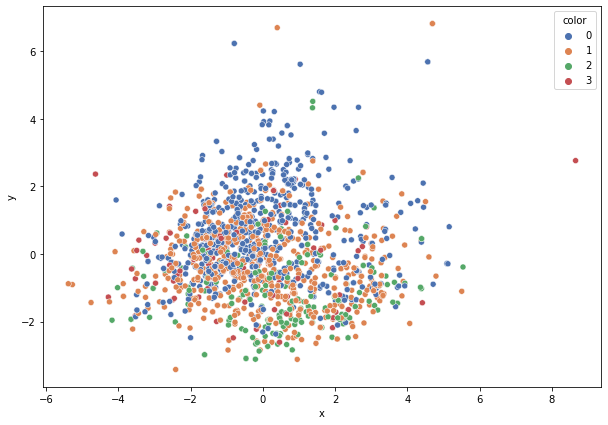

In [36]:
X_embedded = PCA(n_components=2).fit_transform(X)
plot_embeddings(X_embedded, y)

In [41]:
class Print(nn.Module):
    def __init__(self):
        super(Print, self).__init__()
    
    def forward(self, x):
        # Do your print / debug stuff here
        print(x.shape)
        return x

class EmbeddingNet(nn.Module):
    def __init__(self):
        super(EmbeddingNet, self).__init__()
        self.fc = nn.Sequential(nn.Linear(11, 256),
                                nn.PReLU(),
                                nn.Linear(256, 128),
                                nn.PReLU(),
                                nn.Linear(128, 2)
                                )

    def forward(self, x):
        output = self.fc(x)
        return output
    
    def embed(self, x):
        return self.forward(x)
    

class ClassificationNet(nn.Module):
    def __init__(self, embedding_net, n_classes):
        super(ClassificationNet, self).__init__()
        self.embedding_net = embedding_net
        self.n_classes = n_classes
        self.nonlinear = nn.PReLU()
        self.fc1 = nn.Linear(2, n_classes)

    def forward(self, x):
        output = self.embedding_net(x)
        output = self.nonlinear(output)
        scores = F.log_softmax(self.fc1(output), dim=-1)
        return scores
    
    def embed(self,x):
        return self.embedding_net(x)
    
    
class TripletNet(nn.Module):
    def __init__(self, embedding_net):
        super(TripletNet, self).__init__()
        self.embedding_net = embedding_net

    def forward(self, x1, x2, x3):
        output1 = self.embedding_net(x1)
        output2 = self.embedding_net(x2)
        output3 = self.embedding_net(x3)
        return output1, output2, output3
    
    def embed(self, x):
        return self.embedding_net(x)

In [46]:
def train_tripletnet(model, device, train_loader, optimizer, epoch, log_interval = 10, dry_run=False):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        target_weights = []
        for t in target[0]:
            target_weights.append(weights[t.item()])
#         print(target_weights)
        data[0] = torch.reshape(data[0], (data[0].shape[0],11))
        data[1] = torch.reshape(data[1], (data[0].shape[0],11))
        data[2] = torch.reshape(data[2], (data[0].shape[0],11))
        data = tuple(d.cuda() for d in data)
        
        optimizer.zero_grad()        
        outputs = model(*data)
        loss_inputs = outputs
        w = torch.Tensor(np.array(target_weights)).to(device)
        loss_fn = TripletLossWeighted(2.0, weights=w)
        
        loss_outputs = loss_fn(*loss_inputs)
        loss = loss_outputs[0] if type(loss_outputs) in (tuple, list) else loss_outputs
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            
def test_tripletnet(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data[0] = torch.reshape(data[0], (data[0].shape[0],11))
            data[1] = torch.reshape(data[1], (data[0].shape[0],11))
            data[2] = torch.reshape(data[2], (data[0].shape[0],11))
            data = tuple(d.cuda() for d in data)
            
            outputs = model(*data)

            loss_inputs = outputs
            loss_fn = TripletLoss(1.0)

            loss_outputs = loss_fn(*loss_inputs)
            loss = loss_outputs[0] if type(loss_outputs) in (tuple, list) else loss_outputs
            test_loss += loss.item()

    test_loss

    print('\nTest set: Average loss: {:.4f}\n'.format(test_loss))

In [47]:
seed = 7
batch_size = 32
test_batch_size = 32
use_cuda = True
lr = 1e-3
gamma = 0.9
epochs = 200
save_model = True
log_interval = 20

torch.manual_seed(seed)

device = torch.device("cuda" if use_cuda else "cpu")

train_kwargs = {'batch_size': batch_size}
test_kwargs = {'batch_size': test_batch_size}
if use_cuda: 
    cuda_kwargs = {'num_workers': 1,
                   'pin_memory': True,
                   'shuffle': True}
    train_kwargs.update(cuda_kwargs)
    test_kwargs.update(cuda_kwargs)


dataset1 = TensorDataset(torch.Tensor(X_train),torch.Tensor(y_train))
dataset1.train_data = torch.Tensor(X_train)
dataset1.train_labels = torch.Tensor(y_train)
dataset1.train = True

dataset2 = TensorDataset(torch.Tensor(X_test), torch.Tensor(y_test))
dataset2.test_data = torch.Tensor(X_test)
dataset2.test_labels = torch.Tensor(y_test)
dataset2.train = False

triplet_train_dataset = TripletCleveland(dataset1)
triplet_test_dataset = TripletCleveland(dataset2)

triplet_train_loader = torch.utils.data.DataLoader(triplet_train_dataset, **train_kwargs)
triplet_test_loader = torch.utils.data.DataLoader(triplet_test_dataset, **test_kwargs)

embedding_net = EmbeddingNet()
model = TripletNet(embedding_net).to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)

scheduler = StepLR(optimizer, step_size=1, gamma=gamma)
for epoch in range(1, epochs + 1):
    train_tripletnet(model, device, triplet_train_loader, optimizer, epoch, log_interval)
    test_tripletnet(model, device, triplet_test_loader)
    scheduler.step()

if save_model:
    torch.save(model.state_dict(), "mnist_cnn_triplet.pt")

Train Epoch: 1 [0/1199 (0%)]	Loss: 0.642976
Train Epoch: 1 [60/1199 (53%)]	Loss: 0.698818

Test set: Average loss: 13.1057

Train Epoch: 2 [0/1199 (0%)]	Loss: 0.540285
Train Epoch: 2 [60/1199 (53%)]	Loss: 0.714656

Test set: Average loss: 12.2894

Train Epoch: 3 [0/1199 (0%)]	Loss: 0.602034
Train Epoch: 3 [60/1199 (53%)]	Loss: 0.394217

Test set: Average loss: 11.7898

Train Epoch: 4 [0/1199 (0%)]	Loss: 1.103876
Train Epoch: 4 [60/1199 (53%)]	Loss: 0.637083

Test set: Average loss: 11.0389

Train Epoch: 5 [0/1199 (0%)]	Loss: 0.658721
Train Epoch: 5 [60/1199 (53%)]	Loss: 0.503087

Test set: Average loss: 13.6355

Train Epoch: 6 [0/1199 (0%)]	Loss: 0.686090
Train Epoch: 6 [60/1199 (53%)]	Loss: 0.455795

Test set: Average loss: 12.8696

Train Epoch: 7 [0/1199 (0%)]	Loss: 0.424930
Train Epoch: 7 [60/1199 (53%)]	Loss: 0.606965

Test set: Average loss: 11.3191

Train Epoch: 8 [0/1199 (0%)]	Loss: 0.348343
Train Epoch: 8 [60/1199 (53%)]	Loss: 0.602265

Test set: Average loss: 11.4498

Train Ep


Test set: Average loss: 12.6119

Train Epoch: 67 [0/1199 (0%)]	Loss: 0.366329
Train Epoch: 67 [60/1199 (53%)]	Loss: 0.619878

Test set: Average loss: 12.7009

Train Epoch: 68 [0/1199 (0%)]	Loss: 0.686700
Train Epoch: 68 [60/1199 (53%)]	Loss: 0.592375

Test set: Average loss: 12.5149

Train Epoch: 69 [0/1199 (0%)]	Loss: 0.455409
Train Epoch: 69 [60/1199 (53%)]	Loss: 0.452927

Test set: Average loss: 12.4832

Train Epoch: 70 [0/1199 (0%)]	Loss: 0.340186
Train Epoch: 70 [60/1199 (53%)]	Loss: 0.303031

Test set: Average loss: 12.5999

Train Epoch: 71 [0/1199 (0%)]	Loss: 0.292057
Train Epoch: 71 [60/1199 (53%)]	Loss: 0.584337

Test set: Average loss: 12.5583

Train Epoch: 72 [0/1199 (0%)]	Loss: 0.590247
Train Epoch: 72 [60/1199 (53%)]	Loss: 0.738918

Test set: Average loss: 12.6089

Train Epoch: 73 [0/1199 (0%)]	Loss: 0.600012
Train Epoch: 73 [60/1199 (53%)]	Loss: 0.369909

Test set: Average loss: 12.6746

Train Epoch: 74 [0/1199 (0%)]	Loss: 0.567005
Train Epoch: 74 [60/1199 (53%)]	Loss: 0


Test set: Average loss: 12.7722

Train Epoch: 132 [0/1199 (0%)]	Loss: 0.461280
Train Epoch: 132 [60/1199 (53%)]	Loss: 0.454504

Test set: Average loss: 12.7030

Train Epoch: 133 [0/1199 (0%)]	Loss: 0.332910
Train Epoch: 133 [60/1199 (53%)]	Loss: 0.345999

Test set: Average loss: 12.3310

Train Epoch: 134 [0/1199 (0%)]	Loss: 0.472487
Train Epoch: 134 [60/1199 (53%)]	Loss: 0.368666

Test set: Average loss: 12.3261

Train Epoch: 135 [0/1199 (0%)]	Loss: 0.683376
Train Epoch: 135 [60/1199 (53%)]	Loss: 0.588157

Test set: Average loss: 12.8967

Train Epoch: 136 [0/1199 (0%)]	Loss: 0.434587
Train Epoch: 136 [60/1199 (53%)]	Loss: 0.574134

Test set: Average loss: 12.4810

Train Epoch: 137 [0/1199 (0%)]	Loss: 0.621922
Train Epoch: 137 [60/1199 (53%)]	Loss: 0.350061

Test set: Average loss: 12.6756

Train Epoch: 138 [0/1199 (0%)]	Loss: 0.341275
Train Epoch: 138 [60/1199 (53%)]	Loss: 0.899859

Test set: Average loss: 12.7316

Train Epoch: 139 [0/1199 (0%)]	Loss: 0.681083
Train Epoch: 139 [60/119

Train Epoch: 196 [0/1199 (0%)]	Loss: 0.338651
Train Epoch: 196 [60/1199 (53%)]	Loss: 0.529503

Test set: Average loss: 12.6023

Train Epoch: 197 [0/1199 (0%)]	Loss: 0.493211
Train Epoch: 197 [60/1199 (53%)]	Loss: 0.540758

Test set: Average loss: 12.7814

Train Epoch: 198 [0/1199 (0%)]	Loss: 0.292703
Train Epoch: 198 [60/1199 (53%)]	Loss: 0.696979

Test set: Average loss: 12.5054

Train Epoch: 199 [0/1199 (0%)]	Loss: 0.315756
Train Epoch: 199 [60/1199 (53%)]	Loss: 0.362426

Test set: Average loss: 12.3692

Train Epoch: 200 [0/1199 (0%)]	Loss: 0.245680
Train Epoch: 200 [60/1199 (53%)]	Loss: 0.558081

Test set: Average loss: 12.5715



100%|██████████| 400/400 [00:00<00:00, 3295.66it/s]


Text(0.5, 1.0, 'Test embeddings')

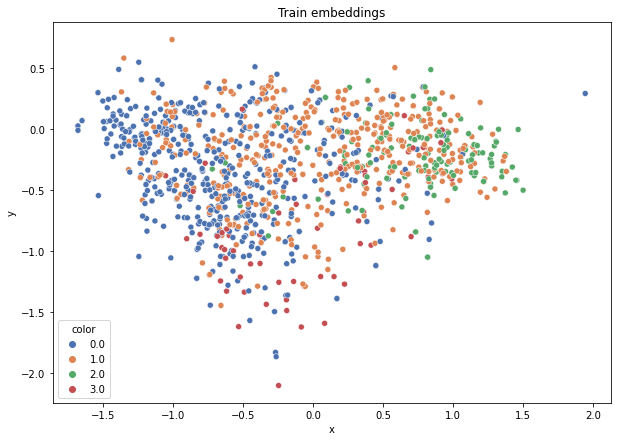

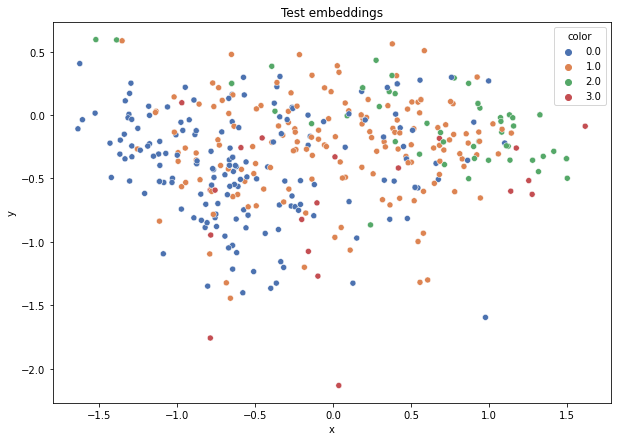

In [48]:
test_loader = torch.utils.data.DataLoader(dataset2, batch_size=1)
train_loader = torch.utils.data.DataLoader(dataset1, batch_size=1)

embeddings, labels = calc_embeddings(model, device, train_loader)
plot_embeddings(embeddings, labels)
plt.title("Train embeddings")

embeddings, labels = calc_embeddings(model, device, test_loader)
plot_embeddings(embeddings, labels)
plt.title("Test embeddings")